In [1]:
!pip install pmdarima

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
import warnings

In [3]:
from math import sqrt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [4]:
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('../../data/sensor1.csv')

In [6]:
df = df.dropna()

In [7]:
units_dict = {}

for col in df.columns[1:]:
    values = []
    units = set()
    for val in df[col]:
        value, unit = val.split()
        values.append(value)
        units.add(unit)
    new_col_name = f"{col} ({units.pop()})"
    df.rename(columns={col: new_col_name}, inplace=True)
    df[new_col_name] = pd.to_numeric(values)
    units_dict[col] = units

In [8]:
df['Time'] = pd.to_datetime(df['Time'])

In [9]:
df.index = df['Time']
df.drop(columns=['Time'], inplace=True)

In [10]:
df = df.sort_index()

In [11]:
co2 = df["CO2 (ppm)"]

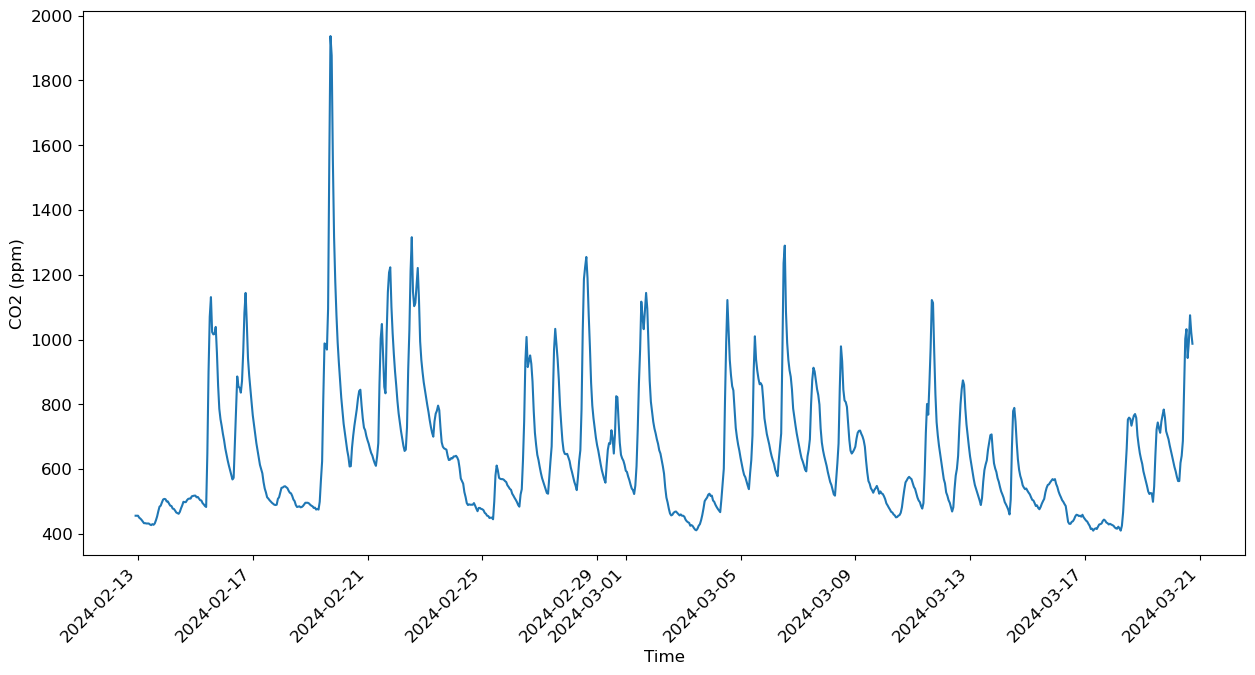

In [12]:
co2.plot(y='CO2 (ppm)', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('CO2 (ppm)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Create training and testing datasets

In [13]:
train_size = int(0.8 * len(df))

In [14]:
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [15]:
train_start_dt = train_df.index[0]
test_start_dt = test_df.index[0]

In [16]:
train_start_dt, test_start_dt

(Timestamp('2024-02-12 22:00:00'), Timestamp('2024-03-13 10:00:00'))

In [17]:
df

,CO2 (ppm),Humidity (%H),PM10 (μg/m³),PM2.5 (μg/m³),Temperature (°C),TVOC (ppm)
Time,,,,,,
2024-02-12 22:00:00,456,79.0,5.60,5.60,24.0,0.642
2024-02-12 23:00:00,456,79.0,5.25,5.13,24.1,0.711
2024-02-13 00:00:00,456,79.0,6.00,5.89,24.2,0.744
2024-02-13 01:00:00,450,79.0,6.44,6.33,24.2,0.759
2024-02-13 02:00:00,447,79.0,6.25,5.88,24.3,0.775
...,...,...,...,...,...,...
2024-03-20 14:00:00,943,76.3,18.50,17.80,23.2,0.338
2024-03-20 15:00:00,993,75.8,18.30,18.00,23.2,0.407
2024-03-20 16:00:00,1075,76.3,19.70,18.30,23.2,0.477


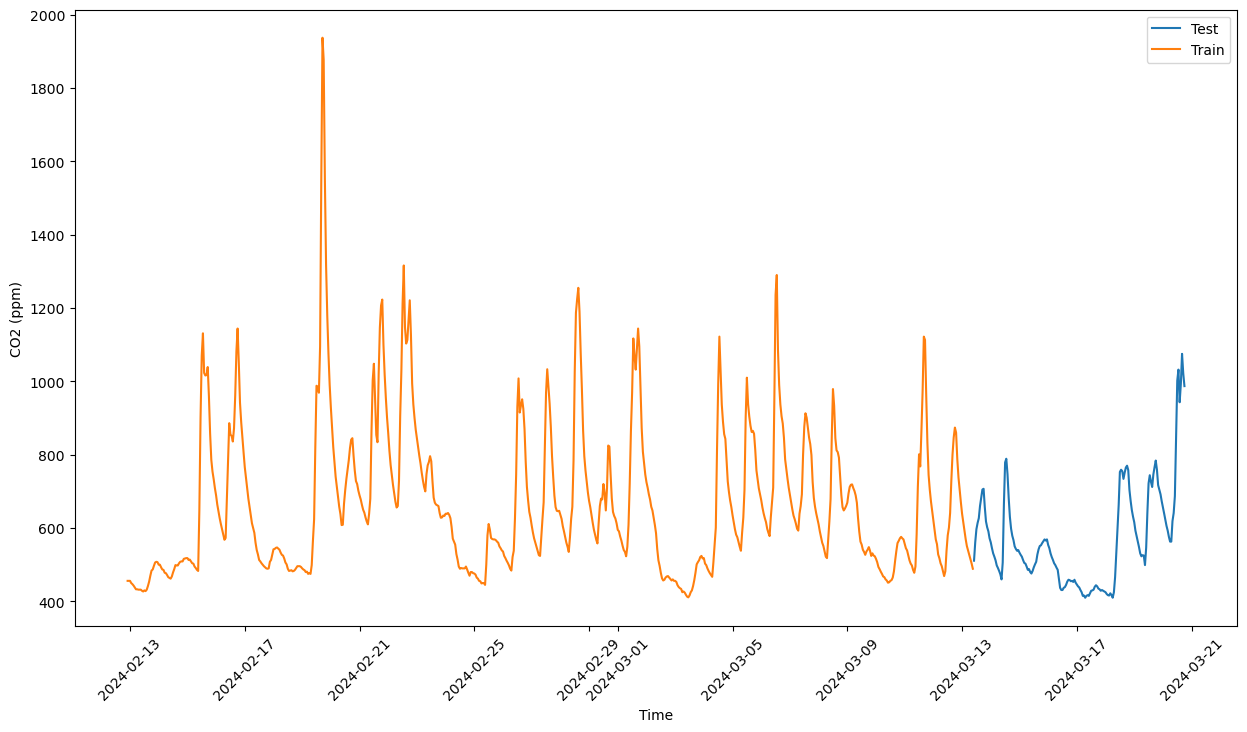

In [18]:
test_co2 = df[df.index >= test_start_dt]["CO2 (ppm)"]
train_co2 = df[(df.index < test_start_dt) & (df.index >= train_start_dt)]["CO2 (ppm)"]

plt.figure(figsize=(15, 8))
plt.plot(test_co2.index, test_co2.values, label='Test')

plt.plot(train_co2.index, train_co2.values, label='Train')

plt.xlabel('Time')
plt.ylabel('CO2 (ppm)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Data preparation

In [19]:
train_co2_reshaped = train_co2.values.reshape(-1, 1)
test_co2_reshaped = test_co2.values.reshape(-1, 1)

In [20]:
print("Training data shape: ", train_co2_reshaped.shape)
print("Test data shape: ", test_co2_reshaped.shape)

Training data shape:  (706, 1)
Test data shape:  (177, 1)


In [21]:
scaler = MinMaxScaler()
train_co2_scaled = scaler.fit_transform(train_co2_reshaped)
train_co2_scaled = pd.DataFrame(train_co2_scaled.flatten(), index=train_co2.index, columns=["CO2 (ppm)"])
train_co2_scaled.head(10)

,CO2 (ppm)
Time,
2024-02-12 22:00:00,0.029489
2024-02-12 23:00:00,0.029489
2024-02-13 00:00:00,0.029489
2024-02-13 01:00:00,0.025557
2024-02-13 02:00:00,0.023591
2024-02-13 03:00:00,0.020970
2024-02-13 04:00:00,0.017693
2024-02-13 05:00:00,0.014417
2024-02-13 06:00:00,0.014417


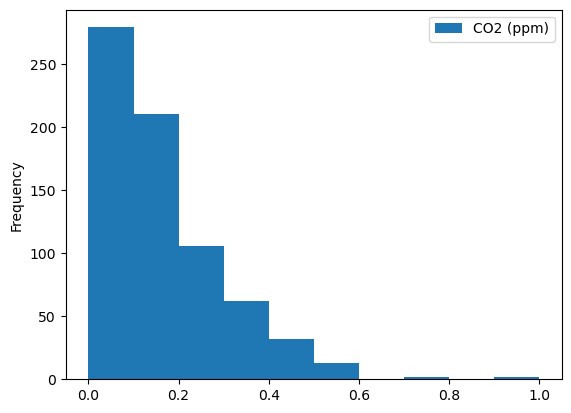

In [22]:
train_co2_scaled.plot.hist(bins=10)
plt.show()

In [23]:
test_co2_scaled = scaler.fit_transform(test_co2_reshaped)
test_co2_scaled = pd.DataFrame(test_co2_scaled.flatten(), index=test_co2.index, columns=["CO2 (ppm)"])
test_co2_scaled.head(10)

,CO2 (ppm)
Time,
2024-03-13 10:00:00,0.151880
2024-03-13 11:00:00,0.227068
2024-03-13 12:00:00,0.281203
2024-03-13 13:00:00,0.306767
2024-03-13 14:00:00,0.326316
2024-03-13 15:00:00,0.375940
2024-03-13 16:00:00,0.410526
2024-03-13 17:00:00,0.443609
2024-03-13 18:00:00,0.446617


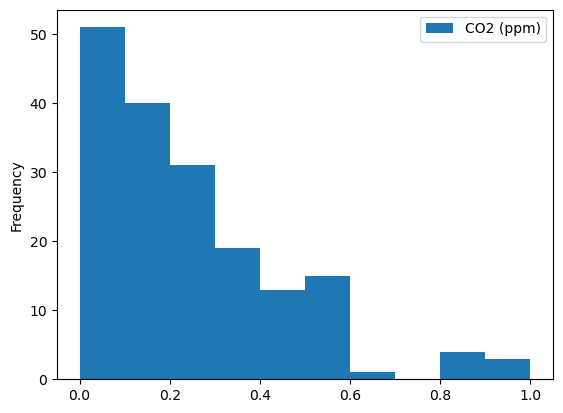

In [24]:
test_co2_scaled.plot.hist(bins=10)
plt.show()

In [25]:
HORIZON_CO2 = 1

In [26]:
stepwise_fit_co2 = auto_arima(train_co2_scaled, trace=True, suppress_warnings=True)
stepwise_fit_co2.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-3024.885, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-810.166, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2564.542, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1677.681, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-154.372, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3018.759, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3018.918, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-3023.740, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-3022.341, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2939.787, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-3027.564, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-2635.007, Time=0.12 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-3026.474, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2274.890, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  706
Model:               SARIMAX(1, 0, 3)   Log Likelihood                1519.782
Date:                Wed, 20 Mar 2024   AIC                          -3027.564
Time:                        18:30:58   BIC                          -3000.206
Sample:                             0   HQIC                         -3016.993
                                - 706                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0225      0.007      3.462      0.001       0.010       0.035
ar.L1          0.8643      0.018     48.315      0.000       0.829       0.899
ma.L1          0.9492      0.018     51.313      0.000       0.913       0.985
ma.L2          0.5090      0.033     15.359      0.000       0.444       0.574
ma.L3          0.1451      0.029      4.995      0.000       0.088       0.202
sigma2         0.0008   1.66e-05     47.326      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              9295.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
order_co2 = (1,0,3)

In [28]:
model_temp =  ARIMA(endog=train_co2_scaled, order=order_co2)
result_temp = model_temp.fit()

print(result_temp.summary())

                               SARIMAX Results                                
Dep. Variable:              CO2 (ppm)   No. Observations:                  706
Model:                 ARIMA(1, 0, 3)   Log Likelihood                1519.782
Date:                Wed, 20 Mar 2024   AIC                          -3027.564
Time:                        18:30:58   BIC                          -3000.206
Sample:                             0   HQIC                         -3016.993
                                - 706                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1660      0.032      5.254      0.000       0.104       0.228
ar.L1          0.8642      0.018     48.297      0.000       0.829       0.899
ma.L1          0.9493      0.019     51.306      0.0

Walk-forward validation

Create a test data point for each HORIZON.<br>
Shift the data horizontally according to its horizon point.

In [29]:
test_co2_shifted = test_co2_scaled.copy()

for t in range(1, HORIZON_CO2):
    test_co2_shifted["CO2 (ppm)+" + str(t)] = test_co2_shifted["CO2 (ppm)"].shift(-t, freq='H')
    
test_co2_shifted = test_co2_shifted.dropna(how='any')
test_co2_shifted.head()

,CO2 (ppm)
Time,
2024-03-13 10:00:00,0.151880
2024-03-13 11:00:00,0.227068
2024-03-13 12:00:00,0.281203
2024-03-13 13:00:00,0.306767
2024-03-13 14:00:00,0.326316


Make predictions on the test data using a sliding window approach in a loop the size of the test data length.

In [30]:
stepwise_fit_co2_test = auto_arima(test_co2_scaled, trace=True, suppress_warnings=True)
stepwise_fit_co2_test.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-654.854, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-545.135, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-618.855, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-651.410, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-546.012, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-656.544, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-658.490, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-656.565, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-657.190, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-654.580, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-659.918, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-652.662, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-657.960, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-657.973, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  177
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 332.959
Date:                Wed, 20 Mar 2024   AIC                           -659.918
Time:                        18:30:58   BIC                           -650.406
Sample:                    03-13-2024   HQIC                          -656.060
                         - 03-20-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9661      0.041     23.733      0.000       0.886       1.046
ma.L2          0.2463      0.049      5.060      0.000       0.151       0.342
sigma2         0.0013   7.55e-05     17.522      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               396.96
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.19   Skew:                             1.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
test_co2_shifted

,CO2 (ppm)
Time,
2024-03-13 10:00:00,0.151880
2024-03-13 11:00:00,0.227068
2024-03-13 12:00:00,0.281203
2024-03-13 13:00:00,0.306767
2024-03-13 14:00:00,0.326316
...,...
2024-03-20 14:00:00,0.801504
2024-03-20 15:00:00,0.876692
2024-03-20 16:00:00,1.000000


In [32]:
%%time
training_window = 168

train_ts_co2 = train_co2_scaled["CO2 (ppm)"]
test_ts_co2 = test_co2_shifted

history_co2 = [x for x in train_ts_co2]
history_co2 = history_co2[(-training_window):]

predictions_co2 = list()

# order = (1,0,3)

for t in range(test_ts_co2.shape[0]):
    model_co2 = ARIMA(endog=history_co2, order=order_co2)
    model_fit_co2 = model_co2.fit()
    yhat = model_fit_co2.forecast(steps = HORIZON_CO2)
    predictions_co2.append(yhat)
    obs = list(test_ts_co2.iloc[t])
    # move the training window
    history_co2.append(obs[0])
    history_co2.pop(0)
    print(test_ts_co2.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2024-03-13 10:00:00
1 : predicted = [0.05090961] expected = [0.15187969924812028]
2024-03-13 11:00:00
2 : predicted = [0.25832841] expected = [0.2270676691729323]
2024-03-13 12:00:00
3 : predicted = [0.2557341] expected = [0.281203007518797]
2024-03-13 13:00:00
4 : predicted = [0.29803258] expected = [0.306766917293233]
2024-03-13 14:00:00
5 : predicted = [0.31368194] expected = [0.3263157894736842]
2024-03-13 15:00:00
6 : predicted = [0.33075317] expected = [0.37593984962406013]
2024-03-13 16:00:00
7 : predicted = [0.40419493] expected = [0.41052631578947363]
2024-03-13 17:00:00
8 : predicted = [0.41534461] expected = [0.4436090225563909]
2024-03-13 18:00:00
9 : predicted = [0.4494379] expected = [0.44661654135338336]
2024-03-13 19:00:00
10 : predicted = [0.42857281] expected = [0.37142857142857144]
2024-03-13 20:00:00
11 : predicted = [0.29100771] expected = [0.31278195488721805]
2024-03-13 21:00:00
12 : predicted = [0.27768543] expected = [0.28872180451127816]
2024-03-13 22:00:00
13

Compare the prediction against the actual CO2.

In [33]:
eval_df_co2 = pd.DataFrame(predictions_co2, columns=['t+'+str(t) for t in range(1, HORIZON_CO2+1)])
eval_df_co2['Time'] = test_co2_scaled.index[0:len(test_co2_scaled.index)-HORIZON_CO2+1]
eval_df_co2 = pd.melt(eval_df_co2, id_vars='Time', value_name='Prediction', var_name='H')
eval_df_co2['Actual'] = np.array(np.transpose(test_ts_co2)).ravel()
eval_df_co2[['Prediction', 'Actual']] = scaler.inverse_transform(eval_df_co2[['Prediction', 'Actual']])
eval_df_co2.head()

,Time,H,Prediction,Actual
0,2024-03-13 10:00:00,t+1,443.854892,511.0
1,2024-03-13 11:00:00,t+1,581.788391,561.0
2,2024-03-13 12:00:00,t+1,580.063173,597.0
3,2024-03-13 13:00:00,t+1,608.191667,614.0
4,2024-03-13 14:00:00,t+1,618.598488,627.0


Check the model accuracy by testing its mean absolute percentage error (MAPE) over all the predictions.

In [34]:
if (HORIZON_CO2 > 1):
    eval_df_co2['APE'] = (eval_df_co2['Prediction'] - eval_df_co2['Actual']).abs()
    print(eval_df_co2.groupby('H')['APE'].mean())

In [35]:
# Mean absolute percentage error
def mape(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return (np.absolute(predictions - actuals) / actuals).mean()

In [36]:
print('Multi-step forecast MAPE: ', mape(eval_df_co2['Prediction'], eval_df_co2['Actual'])*100, '%')

Multi-step forecast MAPE:  2.2732376585501273 %


In [37]:
rmse_co2 = sqrt(mean_squared_error(eval_df_co2['Prediction'], eval_df_co2['Actual']))
rmse_co2

25.870911924751173

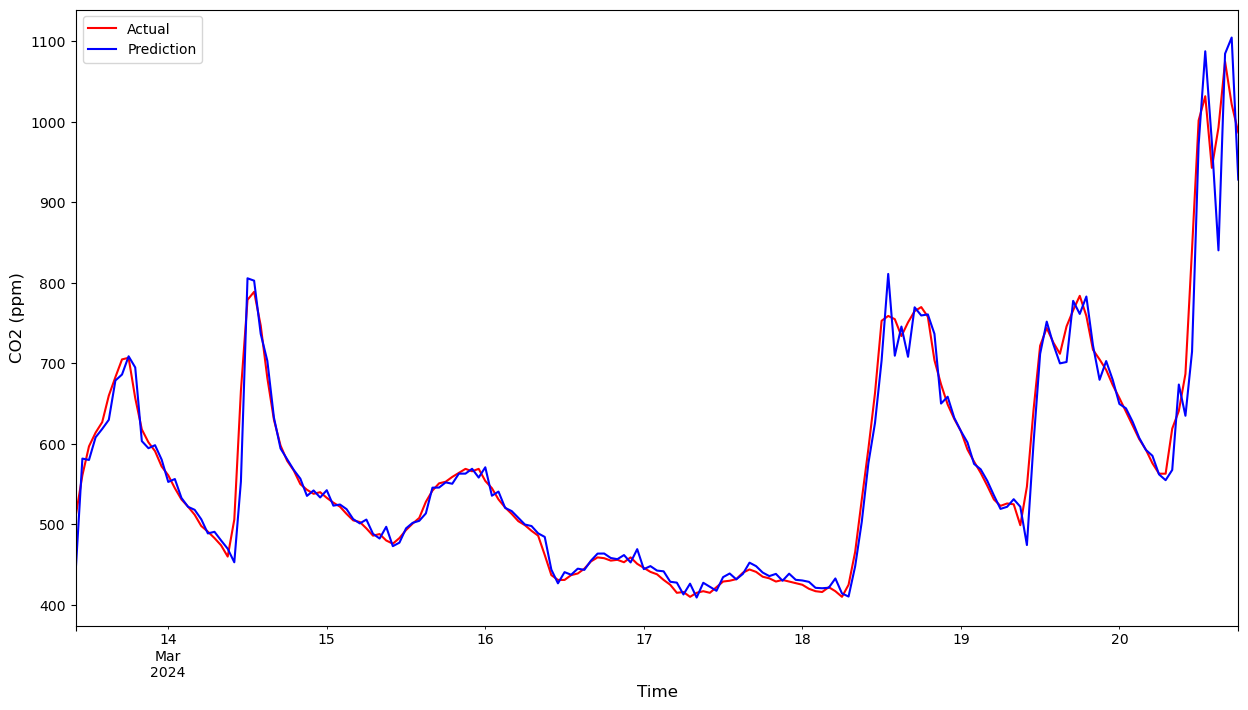

In [38]:
if HORIZON_CO2 == 1:
    eval_df_co2.plot(x='Time', y=['Actual', 'Prediction'], style=['r', 'b'], figsize=(15, 8))
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('CO2 (ppm)', fontsize=12)
    plt.legend(['Actual', 'Prediction'], loc='best')
    plt.show()
else:
    plot_df_co2 = eval_df_co2[(eval_df_co2.H == 't+1')][['Time', 'Actual']]
    for t in range(1, HORIZON_CO2 + 1):
        plot_df_co2['t+' + str(t)] = eval_df_co2[(eval_df_co2.H == 't+' + str(t))]['Prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df_co2['Time'], plot_df_co2['Actual'], color='red', linewidth=4.0, label='Actual')
    for t in range(1, HORIZON_CO2 + 1):
        x = plot_df_co2['Time'][(t - 1):]
        y = plot_df_co2['t+' + str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4 * math.pow(.9, t), alpha=math.pow(0.8, t),
                label='Prediction t+' + str(t))

    ax.legend(loc='best')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('CO2', fontsize=12)
    plt.show()

In [39]:
next_hour = pd.date_range(start=df.index[-1], periods=2, freq='H')[-1]

In [40]:
pred_co2 = model_fit_co2.predict(start=len(df), end=len(df), typ="levels")[0]
pred_co2_nonscaled = round(scaler.inverse_transform(np.array(pred_co2).reshape(-1, 1))[0][0], 1)
print(f"{next_hour} {pred_co2_nonscaled}")

2024-03-20 19:00:00 601.7


In [41]:
with open('arima_co2.pickle', 'wb') as f:
    pickle.dump(model_fit_co2, f)